## NLP2. 멋진 단어사전 만들기

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_class/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_class/ratings_test.txt')

print('train 데이터 사이즈:', len(train_data))
print('test 데이터 사이즈:', len(test_data))

train_data.head()

train 데이터 사이즈: 150000
test 데이터 사이즈: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 분석, 전처리

In [2]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

print('train 데이터 사이즈:', len(train_data))
print('test 데이터 사이즈:', len(test_data))

train 데이터 사이즈: 146182
test 데이터 사이즈: 49157


In [3]:
data = list(train_data['document']) + list(test_data['document'])

print("Data Size:", len(data))

print("Example:")
for sen in data[0:100][::20]: print(">>", sen)

Data Size: 195339
Example:
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


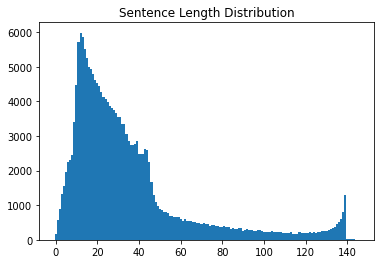

In [4]:
# 문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이분포를 막대그래프로 표현해주는 소스
min_len = 999
max_len = 0
sum_len = 0

for sen in data: 
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(data))

sentence_length = np.zeros((max_len), dtype=int)

for sen in data:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [5]:
# 길이 체크 함수로 문장 길이 확인하기
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

# 훈련 데이터 길이가 1인 문장 확인해보기            
check_sentence_with_length(data, 1)
print("-------------------------------------")
# 훈련 데이터 길이가 146인 문장 확인해보기            
check_sentence_with_length(data, 146)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡
-------------------------------------
"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"
"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"
"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"


In [6]:
# 길이 별로 확인이 필요해보이는 문장 확인하기
for idx, _sum in enumerate(sentence_length):
    # 문장 내 단어의 개수가 5000을 초과하는 인덱스를 추출
    if _sum > 5000:
        print("Outlier Index:", idx+1)

Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17


In [7]:
check_sentence_with_length(data, 12)

아햏햏 아햏햏 아햏햏.
단연 최고라고 할수있지
용가리 진짜짱짱맨이다ㅋ
나름 괜찮은 작품입니다
정말 실망 스러웟음..
무술인이 왜 총을드나?
너무너무 훈훈하네요^^
현실은 꿈, 꿈은 현실
답없네, 뭐하는건지..
엔딩이 넘 슬퍼요 :(
감동감동감동의 도가니탕
정말 최고의 영화...
진짜 짜증나는 영화..
상당히 재밌게 봤습니다
영상미가 역시 최고네요
감독ㅡㅡ다신영화찍지마라
이런 영화가 참 좋다.
정말 광해와 비슷한가?
더빙이 똥이야 ....
잠을 청할 수 있었다.
나오코 진짜 집중안된다
샬라샬라 나오다즁자쥬아
지루하다.. 지루해..
사과해요, 나한테!!!
소재가 굉장히 신선했다
솔직히 산만 하기만했다
OST가 좋은 영화!!
기적은 이미 일어났다.
답을 알려고 하지마라.
평점은 믿지마셈 재밌음
재미 드럽게 없다ㅋㅋㅋ
자식을 그렇게 때리냐?
감동적이였고 좋았습니다
울컥하는 사회현실 ㅠㅠ
등장인물들 모두 짱~~
막장드라마가 따로없구만
말 필요엄따~~~~진정
꿀잼 영화 추억이다ㅜㅜ
맞추자 ㅍ?차븟ㅇㄱ디시
순수하고 아름답다 :)
변태적 성욕 자기합리화
흠....나름 갠찬네요
걍 10점 이라길래..
실력이 필요없는 상황.
감동과 웃음을 한방에!
이거야 이거 ㅋㅋㅋㅋㅋ
성동일딸 시르다...참
평점알바들을 위해 1점
볼만합니다 강추!!ㅋㅋ
이거말고 겨울왕국을봐라
좋은니다..^.,^~~
2.3 (10자 제한)
아무도 안달았네..ㄷㄷ
엉성하고 어설프고...
그냥 보통으로 보았다.
너무 슬픈영화..울음ㅠ
으리는 개뿔 ㅡ,.ㅡ^
처음 본 에로 영화..
평점 조정을 위해...
그냥 쓰레기지 쓰레기~
쵝오네요 최고 대박영화
유전무죄 무전유죄!!!
의외의 꿀잼 이였습니다
어차피 우승은 송민호~
이 때부터가 쓰레기였지
완전 찝찝한 영화...
이상형이 바뀌었습니다.
역시 산드라블록 누님!
결국 엄마가 죽인거네?
그냥 그저 별시리...
추천할만한 경제영화였음
제대로 알아야할 역사임
일본판이더재미있음...
역시 재미있군요 >ㅁ<
아깝다 나의 1점도ㅡㅡ
마음이 따뜻해지는 영화
죽었다. 참 재미없다.

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


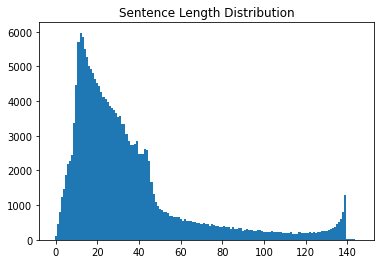

In [8]:
# 데이터에서 중복 제거하기
min_len= 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(data))  # set를 사용해서 중복을 제거
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

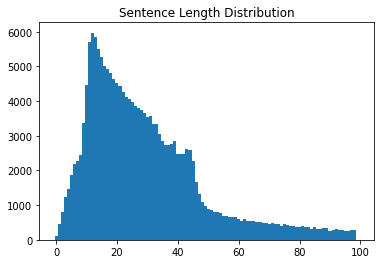

In [9]:
max_len = 100
min_len = 1

# 길이 조건에 맞는 문장만 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려보자 
# 아래 나온 그래프는 최종 데이터 분포
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 네이버 영화 리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

In [10]:
!pip install sentencepiece

In [64]:
import sentencepiece as spm
import os
temp_file =os.getenv('HOME')+'/aiffel/sentiment_class/korean-english-park.train.ko.temp'

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용
        f.write(str(row) + '\n')

# 디폴트 --model_type = 'unigram'
spm.SentencePieceTrainer.Train('--input={} --model_prefix=naver_review_spm --vocab_size={}'.format(temp_file, vocab_size))

# --model_type = 'bpe'
spm.SentencePieceTrainer.Train('--input={} --model_type=bpe --model_prefix=naver_review_spm_bpe --vocab_size={}'.format(temp_file, vocab_size))

!ls -l naver_review_spm*

-rw-r--r-- 1 root root 408104 Oct  1 11:21 naver_review_spm_bpe.model
-rw-r--r-- 1 root root 149302 Oct  1 11:21 naver_review_spm_bpe.vocab
-rw-r--r-- 1 root root 414402 Oct  1 11:21 naver_review_spm.model
-rw-r--r-- 1 root root 185586 Oct  1 11:21 naver_review_spm.vocab


### Sentencepiece 적용
Unigram 타입

In [12]:
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_uni = spm.SentencePieceProcessor() 
s_uni.Load('naver_review_spm.model') # unigram 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_uni.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_uni.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_uni.DecodeIds(tokensIDs))

[1731, 10, 493, 15, 1434, 10, 174, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


BPE 타입

In [13]:
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_bpe = spm.SentencePieceProcessor() 
s_bpe.Load('naver_review_spm_bpe.model') # bpe 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_bpe.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_bpe.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_bpe.DecodeIds(tokensIDs))

[7883, 8551, 8283, 1472, 8279, 8385, 8273, 8271]
['▁아버지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### 토크나이저 구현 및 동작

In [14]:
def sp_tokenize_uni(s_uni, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_uni.EncodeAsIds(sen))

    with open("./naver_review_spm.vocab", 'r') as f: # unigram 타입 vocab
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100)

    return tensor, word_index, index_word

#sp_tokenize(s, corpus) 사용예제로 확인
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor_uni, word_index_uni, index_word_uni = sp_tokenize_uni(s_uni, my_corpus)
print(tensor_uni)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  501 3147   14 1245
  2515    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 1460 2111  232  710

In [15]:
tensor_uni, word_index_uni, index_word_uni = sp_tokenize_uni(s_uni, data)

In [16]:
print(tensor_uni.shape)

(195339, 100)


In [17]:
def sp_tokenize_bpe(s_bpe, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_bpe.EncodeAsIds(sen))

    with open("./naver_review_spm_bpe.vocab", 'r') as f: # bpe 타입 vocab
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100)

    return tensor, word_index, index_word

#sp_tokenize(s, corpus) 사용예제로 확인해
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize_bpe(s_bpe, my_corpus)
print(tensor_bpe)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  721 3152 8300  567
   833 8271]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 1684 2307  320

In [18]:
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize_bpe(s_bpe, data)

In [19]:
print(tensor_bpe.shape)

(195339, 100)


### 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

In [20]:
X_train = tensor_uni[:146182]
X_test = tensor_uni[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 100)
(96182,)


In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 12)                1392      
_________________________________________________________________
dense (Dense)                (None, 8)                 104       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 5s 11ms/step - loss: 0.5359 - accuracy: 0.7322 - val_loss: 0.3753 - val_accuracy: 0.8413
Epoch 2/20
188/188 [==============================] - 2s 9ms/step - loss: 0.3365 - accuracy: 0.8601 - val_loss: 0.3485 - val_accuracy: 0.8500
Epoch 3/20
188/188 [==============================] - 2s 9ms/step - loss: 0.3028 - accuracy: 0.8764 - val_loss: 0.3441 - val_accuracy: 0.8525
Epoch 4/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2876 - accuracy: 0.8830 - val_loss: 0.3463 - val_accuracy: 0.8517
Epoch 5/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2745 - accuracy: 0.8893 - val_loss: 0.3475 - val_accuracy: 0.8513
Epoch 6/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2621 - accuracy: 0.8957 - val_loss: 0.3562 - val_accuracy: 0.8504
Epoch 7/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2492 - accuracy: 0.9020 - val_loss: 0.3635 - val_accuracy: 0.8487
Epoch

1537/1537 - 4s - loss: 0.6878 - accuracy: 0.8249
[0.6878222227096558, 0.8248876333236694]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


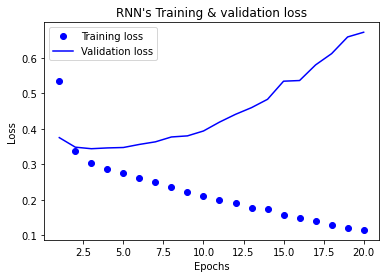

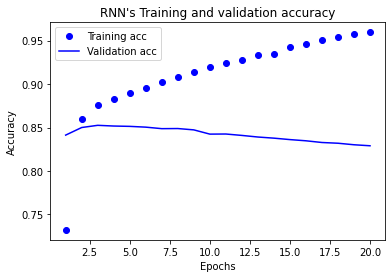

In [23]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* BPE타입의 토크나이저를 적용하여 RNN모델을 학습시켜보자.
* 합쳐진 데이터를 분할하고 검증 데이터도 분할해주자.

In [24]:
X_train = tensor_bpe[:146182]
X_test = tensor_bpe[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 100)
(96182,)


In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 11ms/step - loss: 0.5714 - accuracy: 0.7131 - val_loss: 0.4206 - val_accuracy: 0.8356
Epoch 2/20
188/188 [==============================] - 2s 9ms/step - loss: 0.3518 - accuracy: 0.8561 - val_loss: 0.3503 - val_accuracy: 0.8516
Epoch 3/20
188/188 [==============================] - 2s 9ms/step - loss: 0.3097 - accuracy: 0.8720 - val_loss: 0.3497 - val_accuracy: 0.8515
Epoch 4/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2948 - accuracy: 0.8792 - val_loss: 0.3529 - val_accuracy: 0.8497
Epoch 5/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2845 - accuracy: 0.8855 - val_loss: 0.3583 - val_accuracy: 0.8456
Epoch 6/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2733 - accuracy: 0.8915 - val_loss: 0.3640 - val_accuracy: 0.8489
Epoch 7/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2613 - accuracy: 0.8970 - val_loss: 0.3668 - val_accuracy: 0.8470
Epoch

1537/1537 - 4s - loss: 0.5854 - accuracy: 0.8210
[0.585415244102478, 0.8209817409515381]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


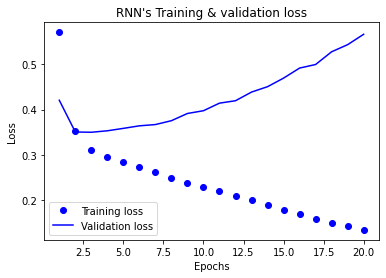

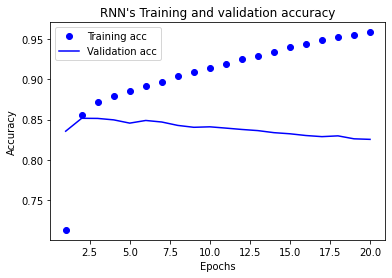

In [27]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

In [28]:
!pip install konlpy

In [29]:
from konlpy.tag import Mecab, Kkma, Komoran, Okt

tokenizer = Mecab()

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] 
num_words = 10000

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [30]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [31]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

* 모델 구성을 위한 데이터 분석 및 가공을 해주자.

In [32]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [33]:
# 데이터셋 내 문장 길이 분포 파악
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [34]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [35]:
# 적절한 최대 문장 길이를 지정
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 설정  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [36]:
# 패딩 작업
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


* RNN 모델 구성 및 검증 데이터셋을 구성해주자.

In [37]:
#  validation set 구성
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 9ms/step - loss: 0.5359 - accuracy: 0.7524 - val_loss: 0.4004 - val_accuracy: 0.8305
Epoch 2/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3542 - accuracy: 0.8526 - val_loss: 0.3523 - val_accuracy: 0.8484
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3196 - accuracy: 0.8688 - val_loss: 0.3497 - val_accuracy: 0.8489
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3017 - accuracy: 0.8761 - val_loss: 0.3495 - val_accuracy: 0.8488
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2896 - accuracy: 0.8819 - val_loss: 0.3525 - val_accuracy: 0.8494
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2776 - accuracy: 0.8886 - val_loss: 0.3624 - val_accuracy: 0.8452
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2657 - accuracy: 0.8937 - val_loss: 0.3637 - val_accuracy: 0.8478
Epoch 

1537/1537 - 3s - loss: 0.5494 - accuracy: 0.8308
[0.5493566989898682, 0.8308277726173401]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


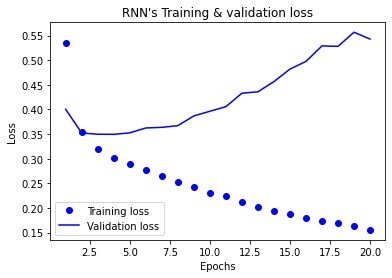

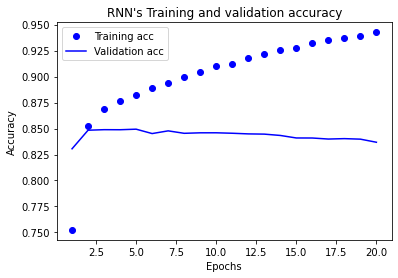

In [40]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
Mec = Mecab()
Kkm = Kkma()
Kom = Komoran()
Okt = Okt()

In [42]:
txt = '사랑하고싶게하는가슴속온감정을헤집어놓는영화예요정말최고'

Mec.pos(txt, flatten=False, join=True) #mecab

[['사랑/NNG',
  '하/XSV',
  '고/EC',
  '싶/VX',
  '게/EC',
  '하/VV',
  '는/ETM',
  '가슴속/NNG',
  '온/VV+ETM',
  '감정/NNG',
  '을/JKO',
  '헤집/VV',
  '어/EC',
  '놓/VX',
  '는/ETM',
  '영화/NNG',
  '예요/VCP+EF',
  '정말/MAG',
  '최고/NNG']]

In [43]:
Kkm.pos(txt,flatten=False, join=True) #kkma

[['사랑/NNG', '하/XSV', '고/ECE'],
 ['싶/VXA', '게/ECD'],
 ['하/VV', '는/ETD'],
 ['가슴속/NNG'],
 ['오/VV', 'ㄴ/ETD'],
 ['감정/NNG', '을/JKO'],
 ['헤집/VV', '어/ECD'],
 ['놓/VXV', '는/ETD'],
 ['영화/NNG', '이/VCP', '에요/EFN'],
 ['정말/MAG'],
 ['최고/NNG']]

In [44]:
Kom.pos(txt,flatten=False, join=True) #komoran

[['사랑/NNG',
  '하/XSV',
  '고/EC',
  '싶/VX',
  '게/EC',
  '하/VX',
  '는/ETM',
  '가슴속/NNG',
  '오/VV',
  'ㄴ/ETM',
  '감정/NNP',
  '을/JKO',
  '헤집/VV',
  '어/EC',
  '놓/VX',
  '는/ETM',
  '영화/NNP',
  '예/NNG',
  '요정/NNP',
  '말/NNG',
  '최고/NNP']]

In [45]:
Okt.pos(txt,norm=True, stem=True, join=True) #okt

['사랑/Noun',
 '하다/Verb',
 '싶다/Verb',
 '가슴속/Noun',
 '온/Noun',
 '감정/Noun',
 '을/Josa',
 '헤집다/Verb',
 '영화/Noun',
 '예요/Josa',
 '정말/Noun',
 '최고/Noun']

In [46]:
s_uni = spm.SentencePieceProcessor() 
print(s_bpe.SampleEncodeAsPieces(txt,1, 0.0))

['▁사랑', '하고싶', '게하는', '가슴', '속', '온', '감', '정을', '헤', '집어', '놓', '는영화', '예요', '정말', '최고']


100%|██████████| 10000/10000 [00:28<00:00, 352.30it/s]


Text(0, 0.5, 'total seconds')

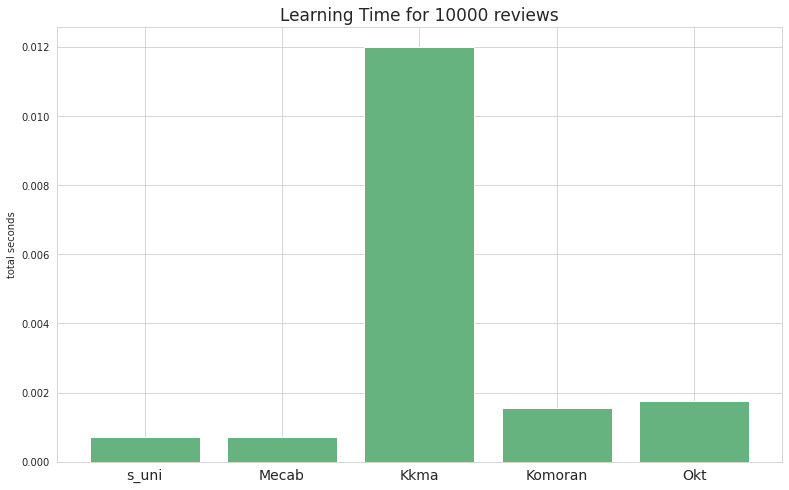

In [62]:
import time
from tqdm import tqdm

s_uni = spm.SentencePieceProcessor()

def tagger_time(tagger, texts):

    time_sum = 0

    for sentence in tqdm(texts):
        t1 = time.time()
        if(tagger==s_uni):
                try:
                    s_uni.SampleEncodeAsPieces(texts,1,0.0)
                except:
                    pass
        else:
                try:
                    tagger.morphs(sentence)
                except:
                    pass
    t2 = time.time()

    time_sum += (t2 - t1)

    return time_sum

texts = train_data['document'][:10000]
time_list = []

for tagger in [s_uni, Mec, Kkm, Kom, Okt]:
    time_list.append(tagger_time(tagger, texts))

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

tagger = ['s_uni', 'Mecab', 'Kkma', 'Komoran', 'Okt']

plt.figure(figsize=(13,8))
plt.bar(tagger, time_list, color=(0.4,0.7,0.5))
plt.title('Learning Time for 10000 reviews', fontsize=17)
plt.xticks(fontsize=14)
plt.ylabel('total seconds')

<회고>  

* sentencepiece의 unigram 타입과 bpe타입에 대해 너무 궁금하여 찾아보았다.  
   a. BPE 타입 :  
BPE(Byte Pair Encoding)은 압축 알고리즘을 이용하여 띄어쓰기 단위의 단어를 subword 단위로 분할하는 알고리즘입니다.   
관련 논문은 <a href="https://arxiv.org/abs/1508.07909">Neural Machine Translation of Rare Words with Subword Units</a>을 참고하면 됩니다.  
<b> 기본적은 동작원리는 subword pair 중 가장 빈도수가 많은 subword pair를 하나의 subword로 합치는 방식입니다. </b>  
   b. Unigram 타입 :  
unigram(Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates)은   
확률기반으로 subword의 발생확률을 최대화하는 방식으로 분할합니다. Sentencepiece의 기본 tokenize 방식은 unigram 입니다.  

이 사실을 토대로 빈도수가 많은 단어들이 발생확률도 클 것으로 예상한다면 성능면에선 많은 차이가 나지 않을 것이다.   
실제로 train 결과를 보면 test_accuracy or val_accuracy가 둘(bpe,unigram) 모두 0.82 대로 비슷했다.

* KoNLPy의 여러 모델과 sentencepiece에 의한 모델과의 비교  
  a. 한국 형태소 분석기중 가장 우수하다는 Mecab은 txt에 나오는 품사들의 띄어쓰기를 잘하였다.  
  b. Kkma는 특히 "예요"를 "이+에+요"로 세분화하여 분리시킨 것이 눈에 띈다. 개인적으로 이 문장에 대해서는 Mecab과 동급인 듯 하다.  
  c. Komoran은 말미에 어미인 "요"와 다음 단어(감탄사)의 첫 글자인 "정"이 합쳐져 "요정"등으로 불필요하게 해석되었다.  
  d. Okt는 단어 자체를 분해하기는 했으나 그 분해한 단어들이 기본형으로 치환되는 양상을 보였다. ex)하고->하다. 싶게->싶다.  
  e. sentencepiece의 unigram에서는 그렇게 어색하지는 않으나 띄어쓰기가 잘 지켜지지 않았고 분해되거나 붙지 말아야 할     
  추상명사와 동사가 있었다.         
  ex) 감정->감 정, 놓는 영화->놓 는영화     
    
*    
   
|모델|띄어쓰기|동사 분해능력|비고|    
|:---|:---|:---|:---|    
|Mecab|우수|중간|띄어쓰기가 철저함|    
|Kkma|우수|우수|동사의 분해능력 좋음|    
|Komoran|낮음|중간|단어간 불필요한 합체|    
|Okt|우수|낮음|동사를 기본형으로 치환|    
|Unigram|낮음|중간|단어간 불필요한 합체나 분해|       
        
* s_uni(sentencepiece의 Unigram 타입)과 KoNLPy의 4가지 모델(Mecab, Kkma, Komoran, Okt)의 수행시간 비교    
  수행시간 : s_uni ~ Mecab < Komoran < Okt < Kkma   